# Analysis of libjpeg - compression

**Author:** Martin Beneš

This notebook contains forensic analysis of compression using various libjpeg versions. Both RGB and grayscale are tested separately. All the other parameters are kept default.

In [2]:
# versions to test
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d']
versions2 = [v[:min(len(v),5)] for v in versions]

# default versions
import jpeglib
v_arbitrary = '9d' # arbitrary version for compression
jpeglib.version.set(v_arbitrary)

# random subsample size
N_samples = 10

# database path
from pathlib import Path
db_path = Path.home() / 'Datasets'

# checkerboard
import numpy as np
def checkerboard(boardsize, tilesize, channels=3):
    board = np.zeros([*boardsize, channels], dtype=np.uint8)
    for i in range(boardsize[0]):
        for j in range(boardsize[1]):
            if (i//tilesize[0]) % 2 == (j//tilesize[1]) % 2:
                board[i,j] = 255
    return board

## Load BOSS

Load BOSSBase database consisting of 10000 grayscale images. It can be downloaded [here](http://agents.fel.cvut.cz/boss/index.php?mode=VIEW&tmpl=materials). For faster execution, we only work with its subsample.

In [3]:
# list BOSS database
import os
boss_path = db_path / 'BOSS' / 'cover'
boss_names = [boss_path / f for f in os.listdir(boss_path)]
print("Loaded BOSS database with", len(boss_names), "images.")

# sample without replacement
import random
random.seed(42) # answer to everything
boss_names_sub = random.sample(boss_names, N_samples)

# load the image with PIL
import matplotlib.pyplot as plt
import numpy as np
boss = np.array([plt.imread(f) for f in boss_names_sub])
boss = np.expand_dims(boss, axis=3)

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    boss = np.append(boss, np.expand_dims(checkerboard((512, 512), tilesize, channels=1), 0), 0)

print("Input shape", boss.shape)

Loaded BOSS database with 10001 images.
Input shape (15, 512, 512, 1)


## Load ALASKA

Load ALASKA2 database consisting of 70000 colored images. In this case we have uncompressed version of shape 256x256. You can find the scripts to download it [here](https://alaska.utt.fr/).

In [4]:
# Load ALASKA2 database
alaska_path = db_path / 'ALASKA_v2_TIFF_256_COLOR'
alaska_names = [alaska_path / f for f in os.listdir(alaska_path)]
print("Loaded ALASKA2 database with", len(alaska_names), "images.")

# sample without replacement
random.seed(42) # answer to everything
alaska_names_sub = random.sample(alaska_names, N_samples)

# load the image with PIL
alaska = np.array([plt.imread(f) for f in alaska_names_sub])

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    alaska = np.append(alaska, np.expand_dims(checkerboard((256, 256), tilesize, 3), 0), 0)

print("Input shape", alaska.shape)

Loaded ALASKA2 database with 80004 images.
Input shape (15, 256, 256, 3)


## Test of SIMD

We test, whether SIMD acceleration of SIMD is used at all. To do so, we compress and decompress ALASKA subsample with 6b and turbo and perform t-test about mean time.

p-values: for compression 6.85E-03, for decompression 4.50E-02


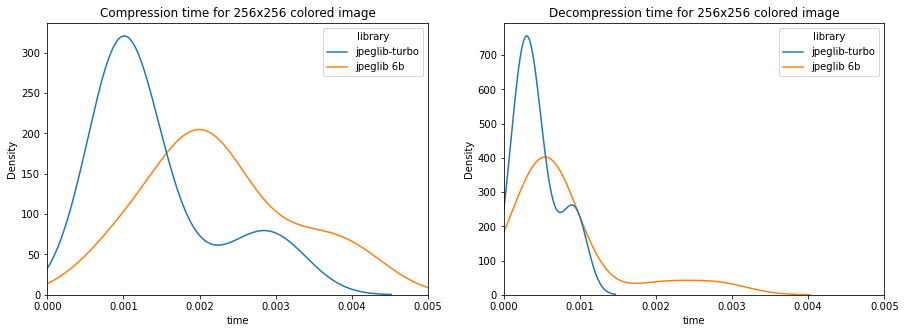

In [6]:
import tempfile
with tempfile.TemporaryDirectory() as tmp:
    fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
    
    # measure each version
    test_versions = ['6b','turbo210']
    t_c,t_d = {v:[] for v in test_versions},{v:[] for v in test_versions} # compression and decompression times
    for version in test_versions:
        with jpeglib.version(version):
            
            # iterate dataset
            for i in range(alaska.shape[0]):
                
                t = jpeglib.Timer('compression')
                im = jpeglib.from_spatial(alaska[i])
                im.samp_factor = ((1,1),(1,1),(1,1))
                im.write_spatial(fnames[i], flags=['+DO_FANCY_DOWNSAMPLING']) # compress
                t_c[version].append(t.stop())
                
                t = jpeglib.Timer('decompression')
                jpeglib.read_spatial(fnames[i], flags=['+DO_FANCY_UPSAMPLING']) # decompress
                t_d[version].append(t.stop())

# Welch's t-test
#   H0: mu_6b <= mu_turbo
#   HA: mu_6b > mu_turbo
from scipy.stats import ttest_ind, ttest_ind_from_stats
_, pc = ttest_ind(t_c['6b'], t_c['turbo210'], alternative='greater', equal_var=False)
_, pd = ttest_ind(t_d['6b'], t_d['turbo210'], alternative='greater', equal_var=False)
print('p-values: for compression %.2E, for decompression %.2E' % (pc,pd))

# plot histograms
import pandas as pd
times_c = pd.concat([pd.DataFrame({'library': 'jpeglib-turbo', 'time': t_c['turbo210']}),
                     pd.DataFrame({'library': 'jpeglib 6b', 'time': t_c['6b']}) ], ignore_index=True)
times_d = pd.concat([pd.DataFrame({'library': 'jpeglib-turbo', 'time': t_d['turbo210']}),
                     pd.DataFrame({'library': 'jpeglib 6b', 'time': t_d['6b']}) ], ignore_index=True)
import seaborn as sns
fig,ax = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=times_c, x="time", hue="library", ax=ax[0]).set_title("Compression time for 256x256 colored image");
sns.kdeplot(data=times_d, x="time", hue="library", ax=ax[1]).set_title("Decompression time for 256x256 colored image");
ax[0].set_xlim(0,.005)
ax[1].set_xlim(0,.005)
plt.show()

## PIL, CV2 and libjpeg

In [22]:
class ImageIO:
    def __init__(self, name): self.name = name
    def compress(self, x): raise NotImplementedError
    def decompress(self): raise NotImplementedError
        
# pillow
from PIL import Image
class PIL_IO(ImageIO):
    def compress(self, x): Image.fromarray(x).save(self.name)
    def decompress(self): return np.array(Image.open(self.name))
    
# opencv
import cv2
class cv2_IO(ImageIO):
    def compress(self, x): cv2.imwrite(self.name, cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    def decompress(self): return cv2.cvtColor(cv2.imread(self.name), cv2.COLOR_BGR2RGB)
    
# matplotlib
class plt_IO(ImageIO):
    def compress(self, x): plt.imsave(self.name, x)
    def decompress(self): return plt.imread(self.name)
    
# libjpeg
class libjpeg_IO(ImageIO):
    def __init__(self, name, version):
        super().__init__(name)
        self.version = version
    def compress(self, x):
        with jpeglib.version(self.version):
            im = jpeglib.from_spatial(x)
            im.write_spatial(self.name)
    def decompress(self):
        with jpeglib.version(self.version):
            return jpeglib.read_spatial(self.name, flags=['+DO_FANCY_UPSAMPLING','+DO_BLOCK_SMOOTHING']).spatial
        
class libjpeg6b_IO(libjpeg_IO):
    def __init__(self, name): super().__init__(name, '6b')
class libjpeg8d_IO(libjpeg_IO):
    def __init__(self, name): super().__init__(name, '8d')
class libjpeg9d_IO(libjpeg_IO):
    def __init__(self, name): super().__init__(name, '9d')
class libjpeg9e_IO(libjpeg_IO):
    def __init__(self, name): super().__init__(name, '9e')
class libjpegturbo_IO(libjpeg_IO):
    def __init__(self, name): super().__init__(name, 'turbo210')

### Compression

In [23]:
# images recompressed by each version
import tempfile
impls = {'PIL':PIL_IO, 'cv2':cv2_IO, 'plt': plt_IO, '6b':libjpeg6b_IO, '8d':libjpeg8d_IO, '9d':libjpeg9d_IO, '9e':libjpeg9d_IO, 'turbo':libjpegturbo_IO}
images_impl = {'impl': [], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for k,impl in impls.items():
        
        # compress each image with version
        fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
        [impl(fname).compress(alaska[i]) for i,fname in enumerate(fnames)]
        
        # decompress with single (arbitrary) version
        images_impl['impl'].append(k)
        images_impl['image'].append(np.array([
            impls['6b'](fname).decompress() for fname in fnames
        ]))

import pandas as pd
images_impl = pd.DataFrame(images_impl)

In [24]:
# distance metric (based on L1)
from scipy.spatial.distance import pdist, squareform
mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

# images to distance matrix
images_impl_list = np.array([list(i) for i in images_impl.image.to_list()], dtype=object)
images_impl_list = images_impl_list.reshape(len(impls), -1)
dists_impl = pdist(images_impl_list, mismatch)
distmat_impl = squareform(dists_impl)

In [25]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for k in range(1,6):
    agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
    agnes.fit(distmat_impl)
    
    # compute heterogenity metric (sum of distances)
    heterogenity = np.sum([ distmat_impl[i,j]
             for group in np.unique(agnes.labels_)
             for i in np.where(agnes.labels_ == group)[0]
             for j in np.where(agnes.labels_ == group)[0] ])
    
    # homogenous clusters
    if heterogenity == 0: break
print(k, "classes:", *[[images_impl.impl.unique()[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

3 classes: ['PIL', 'plt', '8d', '9d', '9e'] ['cv2'] ['6b', 'turbo']


0      PIL
1      cv2
2      plt
3       6b
4       8d
5       9d
6       9e
7    turbo
Name: impl, dtype: object
[[0.         0.69250726 0.         0.10609707 0.         0.
  0.         0.10609707]
 [0.69250726 0.         0.69250726 0.6924842  0.69250726 0.69250726
  0.69250726 0.6924842 ]
 [0.         0.69250726 0.         0.10609707 0.         0.
  0.         0.10609707]
 [0.10609707 0.6924842  0.10609707 0.         0.10609707 0.10609707
  0.10609707 0.        ]
 [0.         0.69250726 0.         0.10609707 0.         0.
  0.         0.10609707]
 [0.         0.69250726 0.         0.10609707 0.         0.
  0.         0.10609707]
 [0.         0.69250726 0.         0.10609707 0.         0.
  0.         0.10609707]
 [0.10609707 0.6924842  0.10609707 0.         0.10609707 0.10609707
  0.10609707 0.        ]]


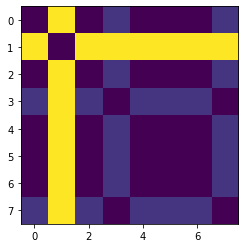

In [26]:
#for i in range()
#images_impl.image.apply(lambda k: k.shape)
#pixel_mismatch
print(images_impl.impl)
plt.imshow(distmat_impl)
print(distmat_impl)
#pixel_mismatch(images_impl.image[4], images_impl.image[1])
#images_impl.image[4].shape

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/49973.tif 0.8196563720703125


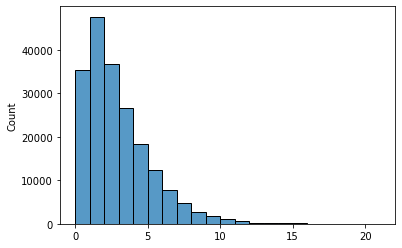

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/66990.tif 0.8675689697265625


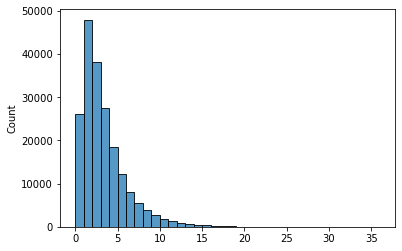

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/77645.tif 0.8271331787109375


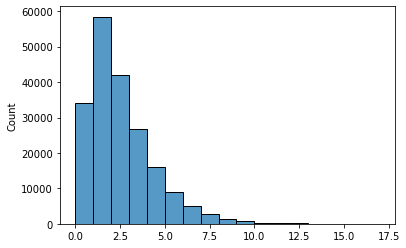

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/31610.tif 0.9445597330729166


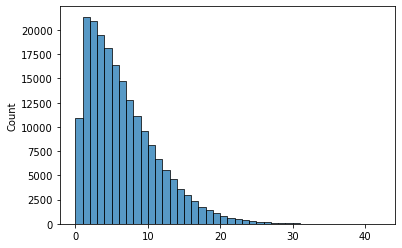

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/60339.tif 0.9024098714192709


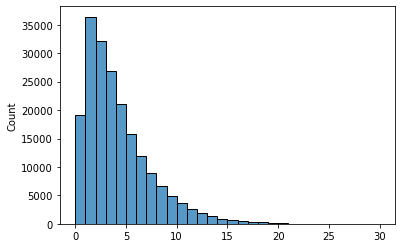

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/78576.tif 0.9208119710286459


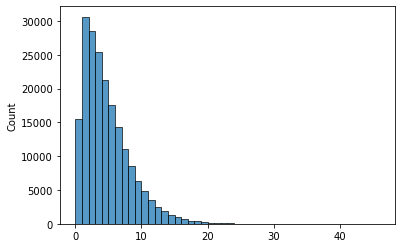

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/57595.tif 0.7766774495442709


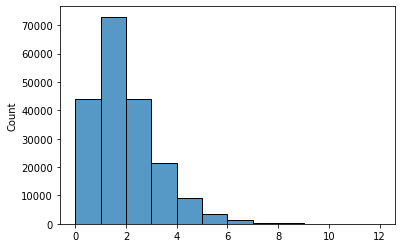

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/21403.tif 0.9233652750651041


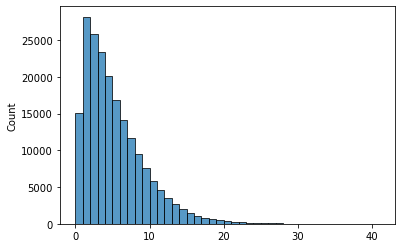

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/67456.tif 0.9222056070963541


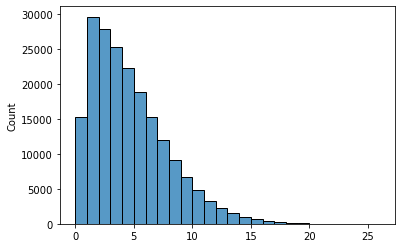

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/68765.tif 0.9267985026041666


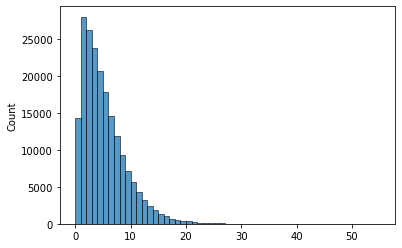

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/47786.tif 0.53125


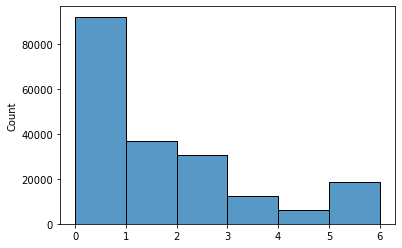

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/56853.tif 0.6558685302734375


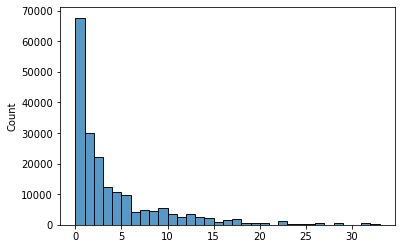

/Users/martin/Datasets/ALASKA_v2_TIFF_256_COLOR/66748.tif 0.36895751953125


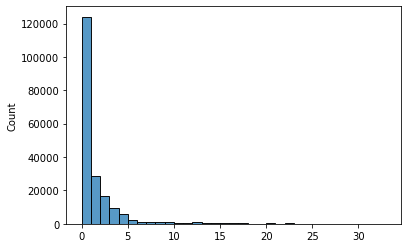

In [27]:
for i in range(len(alaska)):
    xx = alaska[i]
    # compress using cv2
    with tempfile.TemporaryDirectory() as tmp:
        cv2_IO(tmp + '/image.jpeg').compress(xx)
        with jpeglib.version('6b'):
            xy = jpeglib.read_spatial(tmp + '/image.jpeg').spatial
        #xy = libjpeg6b_IO(tmp + '/image.jpeg').decompress()
    # compress using 8d
    with tempfile.NamedTemporaryFile() as tmp:
        with jpeglib.version('6b'):
            jpeglib.from_spatial(xx).write_spatial(tmp.name, qt=75, flags=['DO_FANCY_UPSAMPLING','DO_BLOCK_SMOOTHING'])
        with jpeglib.version('6b'):
            xz = jpeglib.read_spatial(tmp.name).spatial
        #libjpeg6b_IO(tmp.name).compress(xx)
        #xz = libjpeg6b_IO(tmp.name).decompress()
    #'qt': 75, 'in_color_space': 'JCS_RGB', 'flags': ['DO_FANCY_UPSAMPLING']
    D = np.abs(xy.astype(np.int16) - xz.astype(np.int16))
    if (D != 0).mean() > 0:
        print(alaska_names[i], (D != 0).mean())
        #D[D != 0] = 255
        #plt.imshow(D)
        import seaborn as sns
        sns.histplot(D.flatten(), binwidth=1)
        plt.show()

### Decompression

In [31]:
# images recompressed by each version
import tempfile
images_impl = {'impl': [], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for k,impl in impls.items():
        
        # compress each image with version
        fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
        [impls['8d'](fname).compress(alaska[i]) for i,fname in enumerate(fnames)]
        
        # decompress with single (arbitrary) version
        images_impl['impl'].append(k)
        images_impl['image'].append(np.array([
            impl(fname).decompress() for fname in fnames
        ]))

images_impl = pd.DataFrame(images_impl)

In [32]:
# images to distance matrix
images_impl_list = np.array([list(i) for i in images_impl.image.to_list()], dtype=object)
images_impl_list = images_impl_list.reshape(len(impls), -1)
dists_impl = pdist(images_impl_list, pixel_mismatch)
distmat_impl = squareform(dists_impl)

In [33]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for k in range(1,6):
    agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
    agnes.fit(distmat_impl)
    
    # compute heterogenity metric (sum of distances)
    heterogenity = np.sum([ distmat_impl[i,j]
             for group in np.unique(agnes.labels_)
             for i in np.where(agnes.labels_ == group)[0]
             for j in np.where(agnes.labels_ == group)[0] ])
    
    # homogenous clusters
    if heterogenity == 0: break
print(k, "classes:", *[[images_impl.impl.unique()[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

4 classes: ['PIL', 'plt', '9d', '9e'] ['8d'] ['6b', 'turbo'] ['cv2']
